In [1]:
import pathlib
import pickle
import sys
from os import path
_up_one = path.abspath('../')
if _up_one not in sys.path:
    sys.path.insert(1, _up_one)

# Third-party
from astropy.io import ascii
import astropy.table as at
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.integrate import tplquad
from scipy.optimize import minimize

import gala.potential as gp
from gala.units import galactic
from lg_barycentric import LocalGroupBarycentric, mw_masses, m31_masses

coord.galactocentric_frame_defaults.set('v4.0')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [2]:
cache_path = pathlib.Path('../cache')
with open(cache_path / 'models.pkl', 'rb') as f:
    models = pickle.load(f)

In [3]:
m31_cen = coord.SkyCoord(ra='00 42 44.330', dec='+41 16 07.50', distance=779*u.kpc,
                         unit=(u.hourangle, u.degree))

mw_cen = coord.Galactocentric(x=0*u.pc, y=0*u.pc, z=0*u.pc)

In [4]:
for k in models:
    models[k]['mw_xyz'] = mw_cen.transform_to(models[k]['lg_frame']).cartesian.xyz.to(u.kpc)
    models[k]['m31_xyz'] = m31_cen.transform_to(models[k]['lg_frame']).cartesian.xyz.to(u.kpc)

From Mathematica: Intertia tensor notebook

In [5]:
qs = {'0.9': 0.437, 
      '1.2': 0.4,
      '1.5': 0.39}

In [6]:
# OLD: mw_cen and m31_cen need to be in lg coordinates
# pot = gp.CCompositePotential()

# pot['mw'] = gp.NFWPotential(m=_mw_mass, r_s=mw_rs, 
#                             units=galactic,
#                             origin=mw_cen.cartesian.xyz.to(u.kpc))

# pot['m31'] = gp.NFWPotential(m=_m31_mass, r_s=m31_rs, 
#                              units=galactic,
#                              origin=m31_cen.cartesian.xyz)

# grid = np.linspace(-1000, 1000, 128)*u.kpc
# _ = pot.plot_contours(grid=(grid, 0, grid), )

---

In [7]:
nearby = ascii.read('../data/dwarfs.csv')
new = at.Table.read('../data/dwarfs_ell_orbits_mpupdated_0908_simonupdated.csv')

nearby = at.join(new, nearby, keys='GalaxyName',
                 uniq_col_name='{col_name}{table_name}',
                 table_names=['', '_old'])
nearby_new = nearby[[x for x in new.colnames]]

c = coord.SkyCoord(ra=nearby['RA(J2000)'], 
                   dec=nearby['Dec(J2000)'], 
                   distance=nearby['dist_kpc'] * u.kpc,
                   unit=(u.hourangle, u.deg))

In [8]:
mw_lg_frame = LocalGroupBarycentric(mw_mass=1.2e12*u.Msun, 
                                    m31_mass=1*u.Msun)
c_barycen_mw = c.transform_to(mw_lg_frame)

## In fiducial model:

In [9]:
c_barycens = {k: c.transform_to(models[k]['lg_frame']) 
              for k in models}

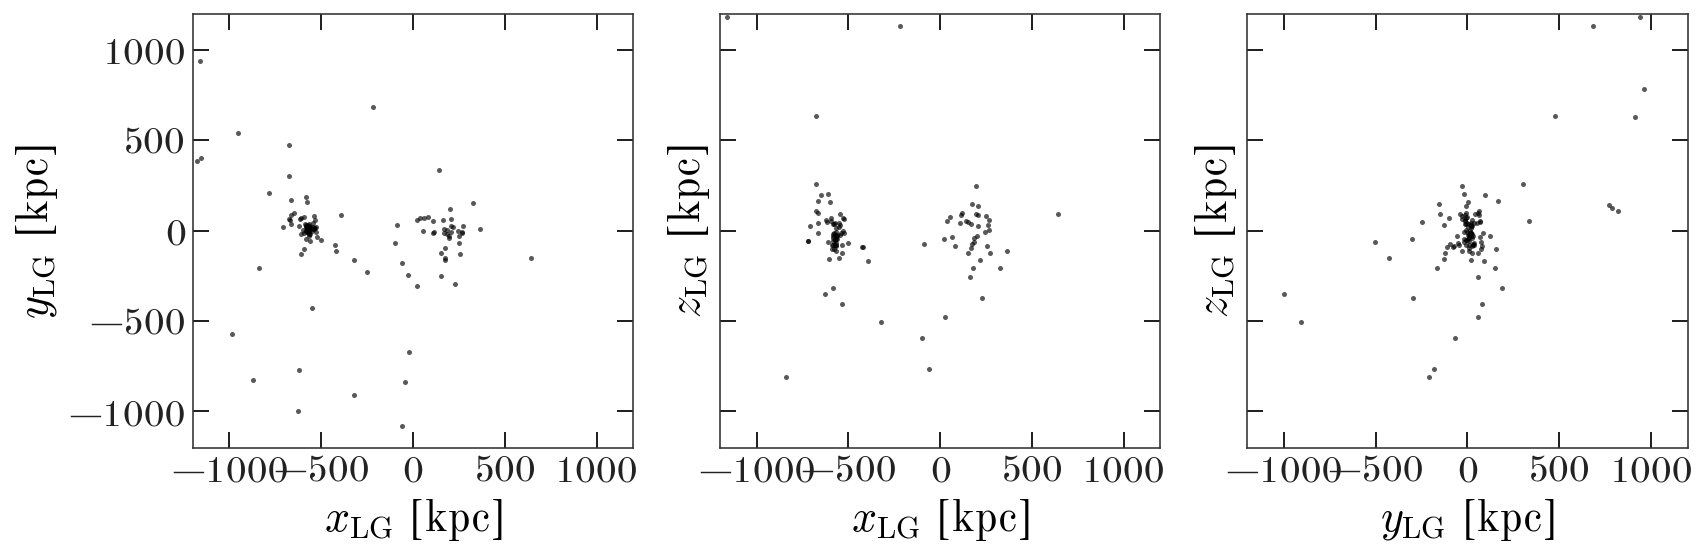

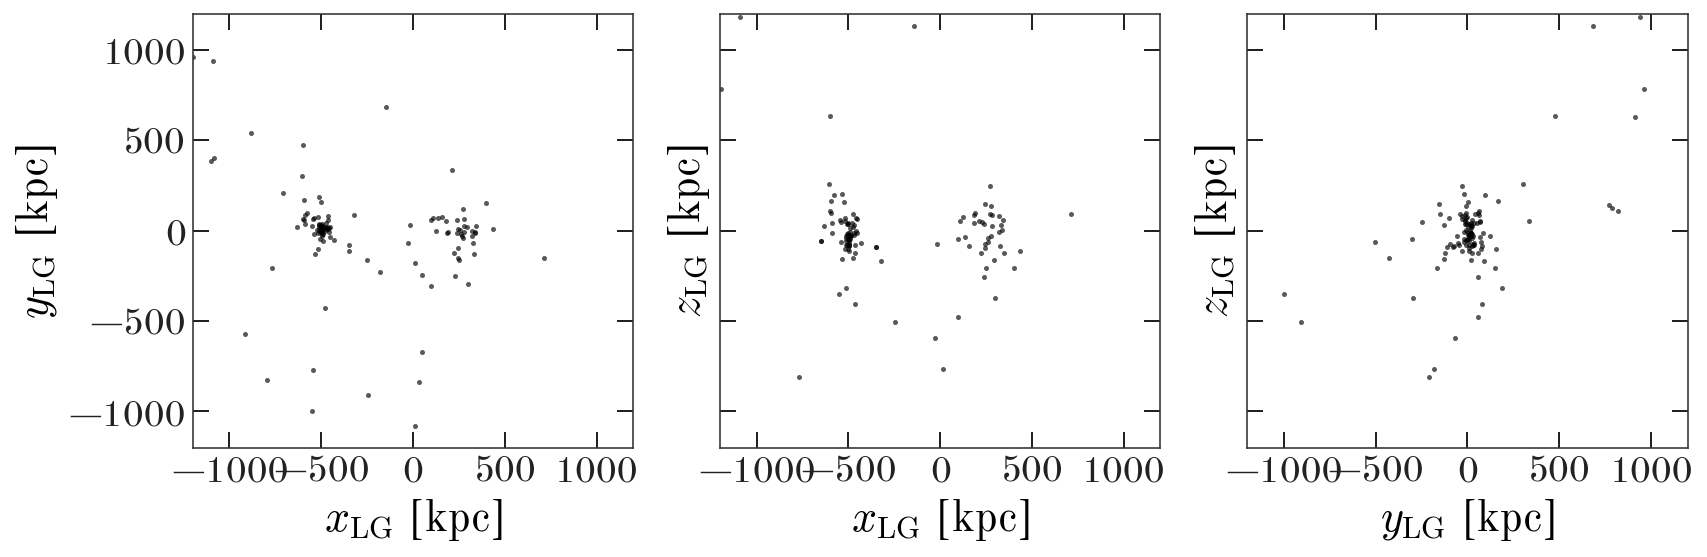

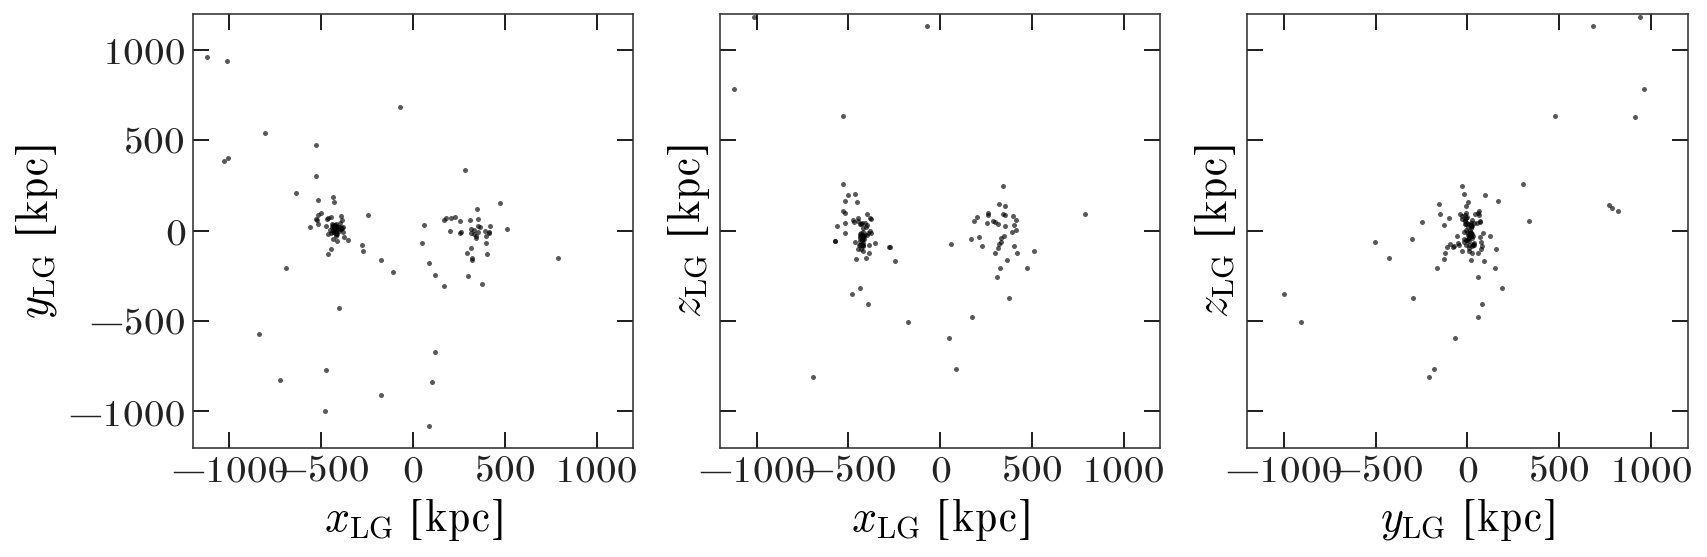

In [10]:
style = dict(marker='.', linestyle='none', alpha=0.65)

for k in models:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                             sharex=True, sharey=True)

    axes[0].plot(c_barycens[k].cartesian.xyz[0],
                 c_barycens[k].cartesian.xyz[1],
                 **style)
    axes[1].plot(c_barycens[k].cartesian.xyz[0],
                 c_barycens[k].cartesian.xyz[2],
                 **style)
    axes[2].plot(c_barycens[k].cartesian.xyz[1],
                 c_barycens[k].cartesian.xyz[2],
                 **style)

    axes[0].set_xlim(-1200, 1200)
    axes[0].set_ylim(-1200, 1200)

    axes[0].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[0].set_ylabel(r'$y_{\rm LG}$ [kpc]')
    axes[1].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[1].set_ylabel(r'$z_{\rm LG}$ [kpc]')
    axes[2].set_xlabel(r'$y_{\rm LG}$ [kpc]')
    axes[2].set_ylabel(r'$z_{\rm LG}$ [kpc]')

    axes[0].xaxis.set_ticks(np.arange(-1000, 1000+1, 500))
    axes[0].yaxis.set_ticks(axes[0].get_xticks())

    fig.tight_layout()

In [11]:
rstars = {}

for k in models:
    th = np.linspace(0, 180, 1024)*u.deg
    xx = models[k]['mw_rvir'] * np.cos(th)
    yy = models[k]['mw_rvir'] * np.sin(th)

    # rstar = np.sqrt(m31_xyz[0]**2 + m31_rvir**2 / q**2).to_value(u.kpc)
    _rstar = np.sqrt((xx-models[k]['mw_xyz'][0])**2 + yy**2 / qs[k]**2).to_value(u.kpc)
    rstars[k] = _rstar.max()
rstars

{'0.9': 780.2316405750969, '1.2': 774.1482132961744, '1.5': 766.5668944103278}

In [12]:
def get_r(cosphi, sinphi, costhe, sinthe, re, q):
    t1 = cosphi**2 * sinthe**2
    t2 = (sinphi**2 * sinthe**2 + costhe**2) / q**2
    return re / np.sqrt(t1 + t2)

def get_xyz_ellipse(phi, the, re, q):
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    costhe = np.cos(the)
    sinthe = np.sin(the)
    
    r = get_r(cosphi, sinphi, costhe, sinthe, re, q)
    x = r * cosphi * sinthe
    y = r * sinphi * sinthe
    z = r * costhe
    
    return np.array([x, y, z])

def is_inside(pt, re, q):
    return (pt[0]**2 / re**2 + (pt[1]**2 + pt[2]**2) / (re**2 * q**2)) <= 1

In [13]:
phi_grid = np.linspace(0, 2*np.pi, 512)
the_grid = np.linspace(-np.pi/2, np.pi/2, 512)
ang_grid = np.vstack(map(np.ravel, np.meshgrid(phi_grid, the_grid)))

<ipython-input-13-936e10afb719>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ang_grid = np.vstack(map(np.ravel, np.meshgrid(phi_grid, the_grid)))


In [14]:
def func(p, xyz):
    phi, the = p
    xyz_el = get_xyz_ellipse(phi, the, rstar, q).T
    return np.sqrt(np.sum((xyz - xyz_el)**2, axis=-1))

In [15]:
closest_ell_xyzs = {}
for k in models:
    q = qs[k]
    rstar = rstars[k]
    bary_xyz = c_barycens[k].cartesian.xyz.value

    closest_ell_xyz = np.zeros((3, bary_xyz.shape[1]))
    count = 0
    for i in range(bary_xyz.shape[1]):
        res = minimize(func, ang_grid[:, func(ang_grid, bary_xyz[:, i]).argmin()], 
                       args=(bary_xyz[:, i],))

        if not res.success:
            count += 1

        closest_ell_xyz[:, i] = get_xyz_ellipse(res.x[0], res.x[1], rstar, q)
    
    print(f"{count} failed")
    closest_ell_xyzs[k] = closest_ell_xyz

26 failed
23 failed
14 failed


In [16]:
xgrid = np.linspace(-1000, 1000, 16384)

<ipython-input-17-f479aecbf308>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-17-f479aecbf308>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-17-f479aecbf308>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-17-f479aecbf308>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-17-f479aecbf308>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-17-f479aecbf308>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)


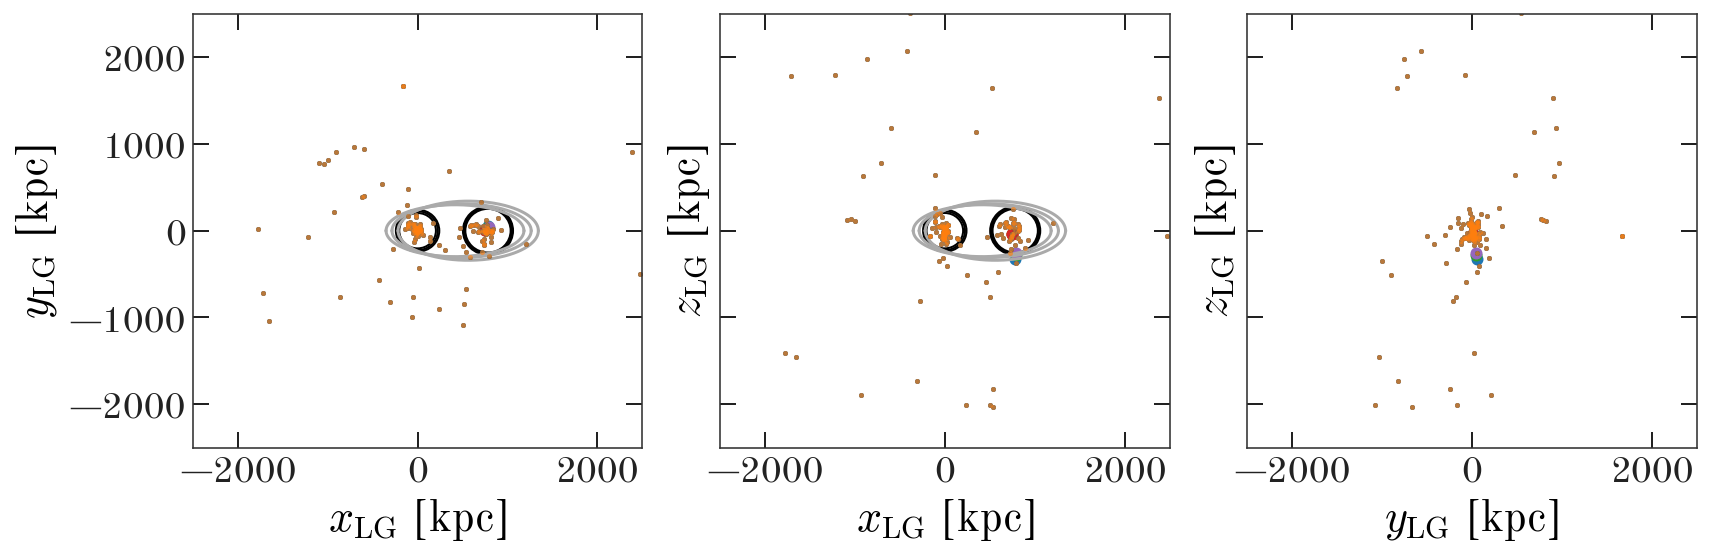

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                             sharex=True, sharey=True)

for key in models:
# for key in ['1.2']:
    q = qs[key]
    rstar = rstars[key]
    _mw_xyz = models[key]['mw_xyz'].to(u.kpc).value
    _m31_xyz = models[key]['m31_xyz'].to(u.kpc).value
    mw_rvir = models[key]['mw_rvir']
    m31_rvir = models[key]['m31_rvir']
    closest_ell_xyz = closest_ell_xyzs[key]
    
    mw_x = models[key]['mw_xyz'].to(u.kpc).value[0]
    dx = mw_x # - models['1.2']['mw_xyz'].to(u.kpc).value[0]

    i = 0

    y1 = q * np.sqrt(rstar**2 - xgrid**2)
    y2 = -q * np.sqrt(rstar**2 - xgrid**2)
    axes[0].plot(xgrid - mw_x, y1, marker='', color='#aaaaaa')
    axes[0].plot(xgrid - mw_x, y2, marker='', color='#aaaaaa')
    axes[1].plot(xgrid - mw_x, y1, marker='', color='#aaaaaa')
    axes[1].plot(xgrid - mw_x, y2, marker='', color='#aaaaaa')

    style = dict(marker='.', linestyle='none', alpha=0.65)

    axes[0].plot(c_barycens[key].cartesian.xyz[0].to_value(u.kpc) - dx,
                   c_barycens[key].cartesian.xyz[1],
                   **style)
    axes[1].plot(c_barycens[key].cartesian.xyz[0].to_value(u.kpc) - dx,
                   c_barycens[key].cartesian.xyz[2],
                   **style)
    axes[2].plot(c_barycens[key].cartesian.xyz[1],
                   c_barycens[key].cartesian.xyz[2],
                   **style)

    axes[0].scatter(c_barycens[key].cartesian.xyz[0, i].to_value(u.kpc) - dx,
                      c_barycens[key].cartesian.xyz[1, i])
    axes[1].scatter(c_barycens[key].cartesian.xyz[0, i].to_value(u.kpc) - dx,
                      c_barycens[key].cartesian.xyz[2, i])
    axes[2].scatter(c_barycens[key].cartesian.xyz[1, i],
                      c_barycens[key].cartesian.xyz[2, i])

    axes[0].scatter(closest_ell_xyz[0, i] - dx,
                      closest_ell_xyz[1, i])
    axes[1].scatter(closest_ell_xyz[0, i] - dx,
                      closest_ell_xyz[2, i])
    axes[2].scatter(closest_ell_xyz[1, i],
                      closest_ell_xyz[2, i])

    axes[0].set_xlim(-2500, 2500)
    axes[0].set_ylim(-2500, 2500)

    axes[0].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[0].set_ylabel(r'$y_{\rm LG}$ [kpc]')
    axes[1].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[1].set_ylabel(r'$z_{\rm LG}$ [kpc]')
    axes[2].set_xlabel(r'$y_{\rm LG}$ [kpc]')
    axes[2].set_ylabel(r'$z_{\rm LG}$ [kpc]')

    for ax in axes[:2]:
        ax.add_patch(mpl.patches.Circle(
            (0, 0), radius=mw_rvir.to_value(u.kpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))

        ax.add_patch(mpl.patches.Circle(
            (_m31_xyz[0] - _mw_xyz[0], 0), radius=m31_rvir.to_value(u.kpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))

    fig.tight_layout()

<ipython-input-18-93cbbb567d34>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-18-93cbbb567d34>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-18-93cbbb567d34>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-18-93cbbb567d34>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-18-93cbbb567d34>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-18-93cbbb567d34>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)


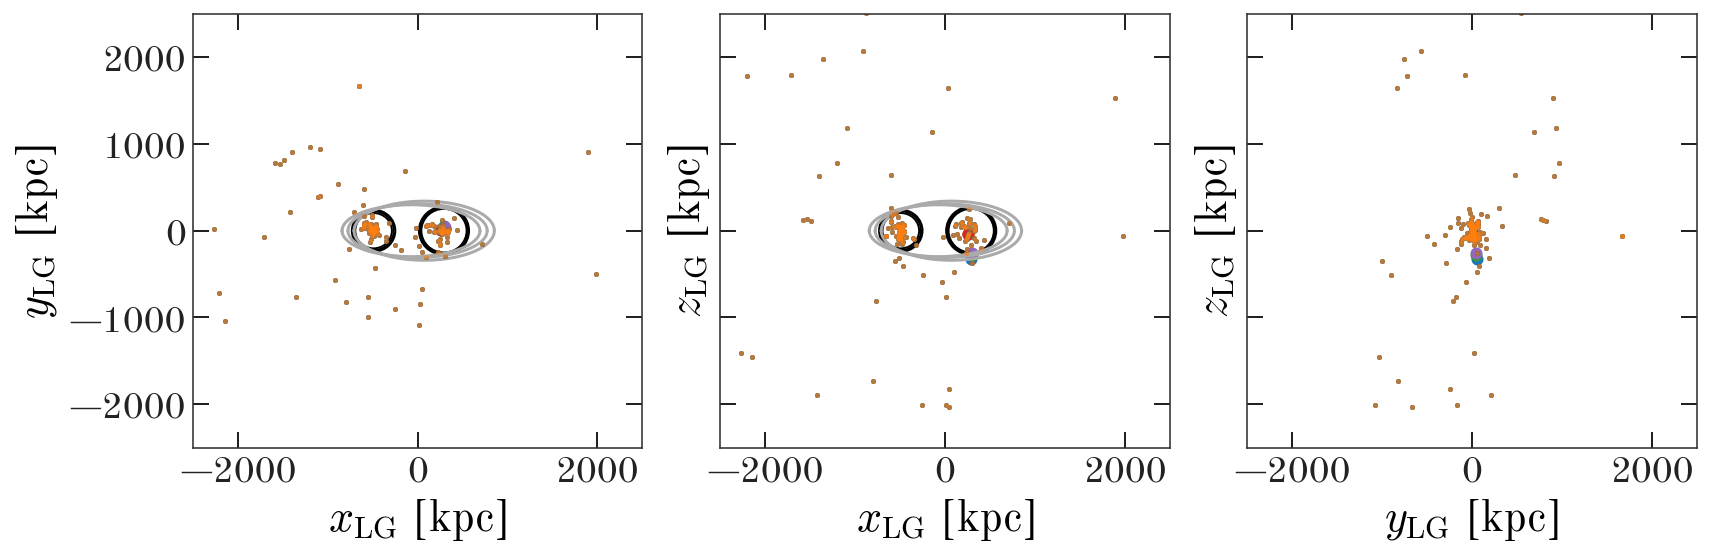

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                             sharex=True, sharey=True)

for key in models:
# for key in ['1.2']:
    q = qs[key]
    rstar = rstars[key]
    _mw_xyz = models[key]['mw_xyz'].to(u.kpc).value
    _m31_xyz = models[key]['m31_xyz'].to(u.kpc).value
    mw_rvir = models[key]['mw_rvir']
    m31_rvir = models[key]['m31_rvir']
    closest_ell_xyz = closest_ell_xyzs[key]
    
    mw_1_2_x = models['1.2']['mw_xyz'].to(u.kpc).value[0]
    dx = models[key]['mw_xyz'].to(u.kpc).value[0] - mw_1_2_x

    i = 0

    y1 = q * np.sqrt(rstar**2 - xgrid**2)
    y2 = -q * np.sqrt(rstar**2 - xgrid**2)
    axes[0].plot(xgrid - dx, y1, marker='', color='#aaaaaa')
    axes[0].plot(xgrid - dx, y2, marker='', color='#aaaaaa')
    axes[1].plot(xgrid - dx, y1, marker='', color='#aaaaaa')
    axes[1].plot(xgrid - dx, y2, marker='', color='#aaaaaa')

    style = dict(marker='.', linestyle='none', alpha=0.65)

    axes[0].plot(c_barycens[key].cartesian.xyz[0].to_value(u.kpc) - dx,
                   c_barycens[key].cartesian.xyz[1],
                   **style)
    axes[1].plot(c_barycens[key].cartesian.xyz[0].to_value(u.kpc) - dx,
                   c_barycens[key].cartesian.xyz[2],
                   **style)
    axes[2].plot(c_barycens[key].cartesian.xyz[1],
                   c_barycens[key].cartesian.xyz[2],
                   **style)

    axes[0].scatter(c_barycens[key].cartesian.xyz[0, i].to_value(u.kpc) - dx,
                      c_barycens[key].cartesian.xyz[1, i])
    axes[1].scatter(c_barycens[key].cartesian.xyz[0, i].to_value(u.kpc) - dx,
                      c_barycens[key].cartesian.xyz[2, i])
    axes[2].scatter(c_barycens[key].cartesian.xyz[1, i],
                      c_barycens[key].cartesian.xyz[2, i])

    axes[0].scatter(closest_ell_xyz[0, i] - dx,
                      closest_ell_xyz[1, i])
    axes[1].scatter(closest_ell_xyz[0, i] - dx,
                      closest_ell_xyz[2, i])
    axes[2].scatter(closest_ell_xyz[1, i],
                      closest_ell_xyz[2, i])

    axes[0].set_xlim(-2500, 2500)
    axes[0].set_ylim(-2500, 2500)

    axes[0].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[0].set_ylabel(r'$y_{\rm LG}$ [kpc]')
    axes[1].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[1].set_ylabel(r'$z_{\rm LG}$ [kpc]')
    axes[2].set_xlabel(r'$y_{\rm LG}$ [kpc]')
    axes[2].set_ylabel(r'$z_{\rm LG}$ [kpc]')

    for ax in axes[:2]:
        ax.add_patch(mpl.patches.Circle(
            (mw_1_2_x, 0), radius=mw_rvir.to_value(u.kpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))

        ax.add_patch(mpl.patches.Circle(
            (_m31_xyz[0] - dx, 0), radius=m31_rvir.to_value(u.kpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))

    fig.tight_layout()

In [19]:
surf_dists = {}
r_ells = {}
for k in models:
    bary_xyz = c_barycens[k].cartesian.xyz.value
    r_ell = np.sqrt(c_barycens[k].x**2 + (c_barycens[k].y**2 + c_barycens[k].z**2) / qs[k]**2)
    surf_dist = np.sqrt(np.sum((bary_xyz - closest_ell_xyzs[k])**2, axis=0))
    surf_dist[is_inside(bary_xyz, rstars[k], qs[k])] *= -1
    
    surf_dists[k] = surf_dist
    r_ells[k] = r_ell

In [20]:
has = ['left', 'right']
vas = ['top', 'bottom']

Make the old plot for the fiducial model:

<ipython-input-21-d4a143eb43a2>:54: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-21-d4a143eb43a2>:55: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-21-d4a143eb43a2>:71: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-21-d4a143eb43a2>:72: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-21-d4a143eb43a2>:71: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-21-d4a143eb43a2>:72: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-21-d4a143eb43a2>:54: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-21-d4a143eb43a2>:55: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 

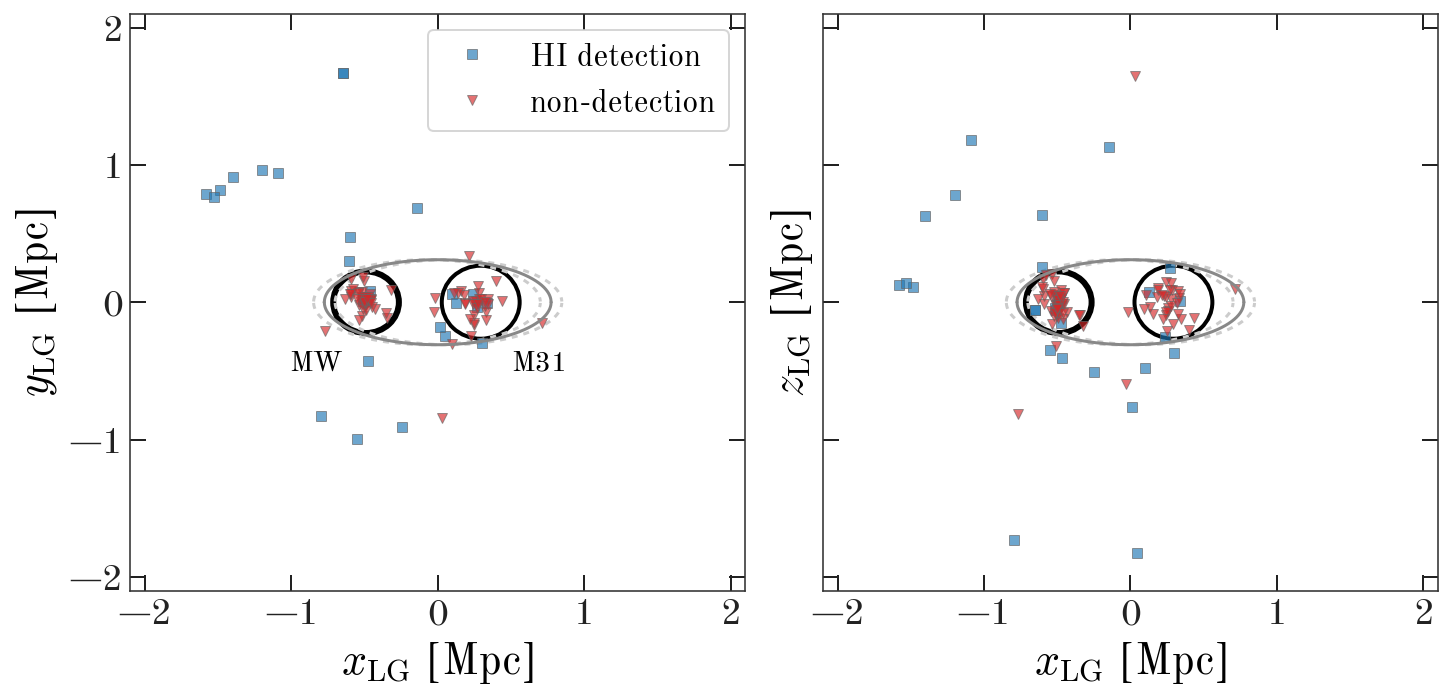

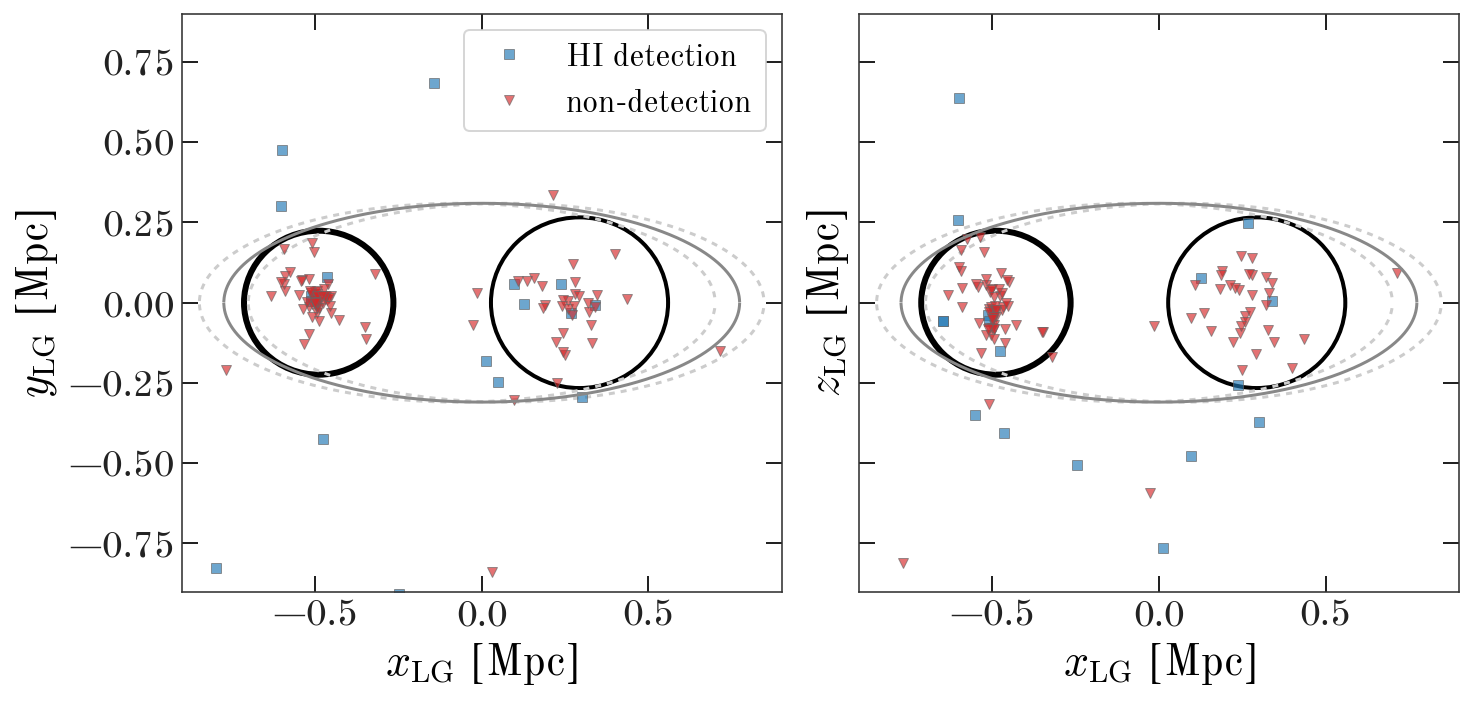

In [21]:
k = '1.2'
model = models[k]
rstar = rstars[k]
q = qs[k]
c_barycen = c_barycens[k]

mask = c.distance < 2*u.Mpc
np.random.seed(1234)

for name, _lim in zip(['', '_zoom'], [2.1, 0.9]):

    fig, axes = plt.subplots(1, 2, figsize=(10.2, 5), 
                             sharex=True, sharey=True)

    has_HI = nearby['MHI_type'] == 'detected_mass'

    for i, ax in zip([1, 2], axes):
        ax.plot(c_barycen.cartesian.xyz[0][mask & has_HI].to(u.Mpc),
                c_barycen.cartesian.xyz[i][mask & has_HI].to(u.Mpc),
                marker='s', ms=5, mew=0.5, mec='#666666',
                linestyle='none', alpha=0.65, color='tab:blue', 
                label='HI detection')
        ax.plot(c_barycen.cartesian.xyz[0][mask & ~has_HI].to(u.Mpc),
                c_barycen.cartesian.xyz[i][mask & ~has_HI].to(u.Mpc),
                marker='v', ms=5, mew=0.5, mec='#666666',
                linestyle='none', alpha=0.65, color='tab:red',
                label='non-detection')

    #     for idx in np.where(mask & has_HI & (surf_dist > 0))[0]:
    #         t = ax.text(c_barycen.cartesian.xyz[0][idx].to_value(u.Mpc),
    #                     c_barycen.cartesian.xyz[i][idx].to_value(u.Mpc),
    #                     s=str(nearby[idx]['id']), fontsize=8, 
    #                     ha=np.random.choice(has), va=np.random.choice(vas))

    #     for idx in np.where(mask & ~has_HI & (surf_dist > 0))[0]:
    #         t = ax.text(c_barycen.cartesian.xyz[0][idx].to_value(u.Mpc),
    #                     c_barycen.cartesian.xyz[i][idx].to_value(u.Mpc),
    #                     s=str(nearby[idx]['id']), fontsize=8, 
    #                     ha=np.random.choice(has), va=np.random.choice(vas))

    axes[0].legend(loc='best', fontsize=16)

    _mw_xyz = model['mw_xyz'].to(u.Mpc).value
    _m31_xyz = model['m31_xyz'].to(u.Mpc).value
    for ax in axes:
        ax.add_patch(mpl.patches.Circle(
            (_mw_xyz[0], 0), radius=model['mw_rvir'].to_value(u.Mpc),
            facecolor='none', lw=3., edgecolor='k', zorder=-100))

        ax.add_patch(mpl.patches.Circle(
            (_m31_xyz[0], 0), radius=model['m31_rvir'].to_value(u.Mpc),
            facecolor='none', lw=2., edgecolor='k', zorder=-100))

    y1 = q * np.sqrt(rstar**2 - xgrid**2)
    y2 = -q * np.sqrt(rstar**2 - xgrid**2)
    for ax in axes:
        ax.plot(xgrid / 1e3, y1 / 1e3, marker='', ls='-', color='#888888')
        ax.plot(xgrid / 1e3, y2 / 1e3, marker='', ls='-', color='#888888')

        ax.set_xlim(-_lim, _lim)
        ax.set_ylim(-_lim, _lim)

        ax.set_xlabel(r'$x_{\rm LG}$ [Mpc]')
    
    # Draw ellipses for other models:
    _style = dict(marker='', color='#cccccc', ls='--', zorder=-100, dashes=(2, 2))
    for key in ['0.9', '1.5']:
        mw_1_2_x = models['1.2']['mw_xyz'].to(u.kpc).value[0]
        dx = models[key]['mw_xyz'].to(u.kpc).value[0] - mw_1_2_x

        y1 = q * np.sqrt(rstar**2 - xgrid**2)
        y2 = -q * np.sqrt(rstar**2 - xgrid**2)
        xx = (xgrid - dx) / 1e3
        axes[0].plot(xx, y1 / 1e3, **_style)
        axes[0].plot(xx, y2 / 1e3, **_style)
        axes[1].plot(xx, y1 / 1e3, **_style)
        axes[1].plot(xx, y2 / 1e3, **_style)
    
    axes[0].set_ylabel(r'$y_{\rm LG}$ [Mpc]')
    axes[1].set_ylabel(r'$z_{\rm LG}$ [Mpc]')
    
    if name == "":
#         axes[0].annotate('Milky Way', (_mw_xyz[0] - 0.25, 0.), xytext=(-1.3, -0.7), 
#                          ha='center', fontsize=14, 
#                          arrowprops=dict(arrowstyle="->",
#                                          linewidth=1., color='#aaaaaa',
#                                          connectionstyle="arc3,rad=-.4"))
#         axes[0].annotate('M31', (_m31_xyz[0] + 0.25, 0.), xytext=(+1.3, -0.7), 
#                          ha='center', fontsize=14)
        axes[0].text(-0.65, -0.35, 'MW', fontsize=14, ha='right', va='top')
        axes[0].text(0.5, -0.35, 'M31', fontsize=14, ha='left', va='top')

    fig.tight_layout()
    fig.set_facecolor('w')
    fig.savefig(f'../plots/rvir_ell{name}.pdf', dpi=250)

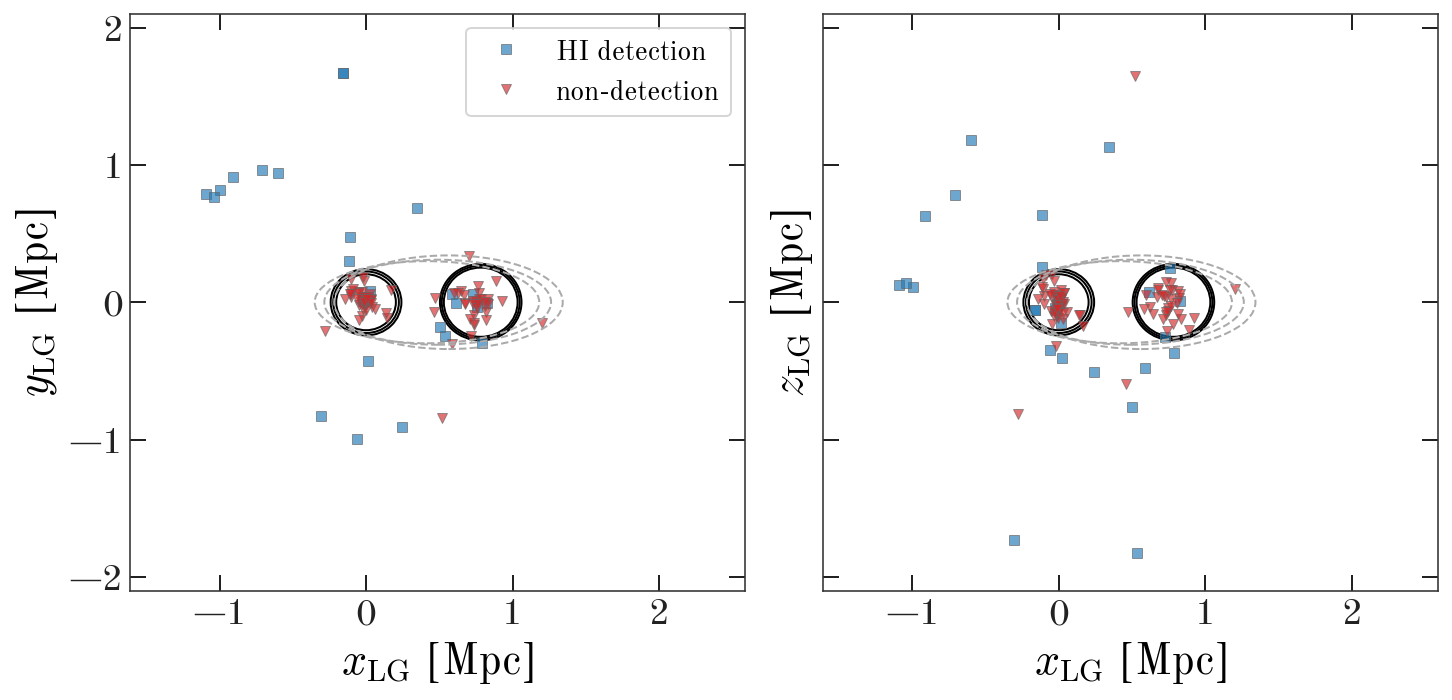

In [22]:
k = '1.2'
model = models[k]
rstar = rstars[k]
q = qs[k]
c_barycen = c_barycens[k]
_mw_xyz = model['mw_xyz'].to(u.Mpc).value
_m31_xyz = model['m31_xyz'].to(u.Mpc).value

x0 = _mw_xyz[0]

mask = c.distance < 2*u.Mpc
np.random.seed(1234)

_lim = 2.1

fig, axes = plt.subplots(1, 2, figsize=(10.2, 5), 
                         sharex=True, sharey=True)

has_HI = nearby['MHI_type'] == 'detected_mass'

for i, ax in zip([1, 2], axes):
    ax.plot(c_barycen.cartesian.xyz[0][mask & has_HI].to_value(u.Mpc) - x0,
            c_barycen.cartesian.xyz[i][mask & has_HI].to_value(u.Mpc),
            marker='s', ms=5, mew=0.5, mec='#666666',
            linestyle='none', alpha=0.65, color='tab:blue', 
            label='HI detection')
    ax.plot(c_barycen.cartesian.xyz[0][mask & ~has_HI].to_value(u.Mpc) - x0,
            c_barycen.cartesian.xyz[i][mask & ~has_HI].to_value(u.Mpc),
            marker='v', ms=5, mew=0.5, mec='#666666',
            linestyle='none', alpha=0.65, color='tab:red',
            label='non-detection')

axes[0].legend(loc='best', fontsize=14)

for ax in axes:
    for k in models:
        ax.add_patch(mpl.patches.Ellipse(
            (-models[k]['mw_xyz'].to(u.Mpc).value[0], 0), 
            width=2 * rstars[k] / 1e3, height=2 * qs[k] * rstars[k] / 1e3,
            facecolor='none', lw=1., edgecolor='#aaaaaa', zorder=5, linestyle='--'))
        
        ax.add_patch(mpl.patches.Circle(
            (_mw_xyz[0] - x0, 0), radius=models[k]['mw_rvir'].to_value(u.Mpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))

        ax.add_patch(mpl.patches.Circle(
            (_m31_xyz[0] - x0, 0), radius=models[k]['m31_rvir'].to_value(u.Mpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))
    
    ax.set_xlim(-_lim - x0, _lim - x0)
    ax.set_ylim(-_lim, _lim)

    ax.set_xlabel(r'$x_{\rm LG}$ [Mpc]')
axes[0].set_ylabel(r'$y_{\rm LG}$ [Mpc]')
axes[1].set_ylabel(r'$z_{\rm LG}$ [Mpc]')

fig.tight_layout()
fig.set_facecolor('w')

In [24]:
# nearby[(surf_dists['0.9'] < 0) != (surf_dists['1.2'] < 0)]

In [25]:
# nearby[(surf_dists['1.2'] < 0) != (surf_dists['1.5'] < 0)]

In [23]:
(surf_dists['0.9'] < 0).sum(), (surf_dists['1.2'] < 0).sum(), (surf_dists['1.5'] < 0).sum()

(92, 91, 90)

In [31]:
# not in fiducial, in low mass
print(nearby[(surf_dists['1.2'] > 0) & (surf_dists['0.9'] < 0)])

# in fiducial, not in low mass
print(nearby[(surf_dists['1.2'] <= 0) & (surf_dists['0.9'] > 0)])

  GalaxyName   RA(J2000) Dec(J2000) ...       r_ell         ell_surf_dist   
-------------- --------- ---------- ... ----------------- ------------------
AndromedaXVIII 0h2m14.5s 45d5m20.0s ... 895.1121741446498 7.0233315798163565
GalaxyName RA(J2000) Dec(J2000) dist_kpc ... m31_dist r_ell ell_surf_dist
---------- --------- ---------- -------- ... -------- ----- -------------


In [32]:
# not in fiducial, in high mass
print(nearby[(surf_dists['1.2'] > 0) & (surf_dists['1.5'] < 0)])

# in fiducial, not in high mass
print(nearby[(surf_dists['1.2'] <= 0) & (surf_dists['1.5'] > 0)])

GalaxyName  RA(J2000)  Dec(J2000) ...       r_ell          ell_surf_dist   
---------- ----------- ---------- ... ----------------- -------------------
     LeoII 11h13m28.8s  22d9m6.0s ... 805.2891469829118 -35.705862932768625
   GalaxyName    RA(J2000)  ...       r_ell          ell_surf_dist   
--------------- ----------- ... ----------------- -------------------
  AndromedaXXII  1h27m40.0s ... 820.4750227421587 -26.238130270026183
AndromedaXXVIII 22h32m41.2s ... 848.8673664380556 -12.724716687111824


---

In [25]:
name_map = {
    '0.9': 'mw-low',
    '1.2': 'fiducial',
    '1.5': 'mw-high'
}

In [26]:
for k, name in name_map.items():
    nearby_new[f'r_ell_{name}'] = r_ells[k]
    nearby_new[f'ell_surf_dist_{name}'] = surf_dists[k]

In [27]:
c_galcen = c.transform_to(coord.Galactocentric())
m31_tmp = m31_cen.transform_to(coord.Galactocentric())
mw_tmp = mw_cen.transform_to(coord.Galactocentric())

dM31 = (c_galcen.cartesian - m31_tmp.cartesian).norm()
dMW = (c_galcen.cartesian - mw_tmp.cartesian).norm()

nearby_new['mw_dist'] = dMW
nearby_new['m31_dist'] = dM31

In [146]:
nearby_new.write('../data/dwarfs_ell_orbits_mpupdated_0908_simonupdated_ell.csv', overwrite=True)

## Audit for Yong's email 2020-11-16

In [29]:
nearby_new[nearby_new['GalaxyName'] == 'PiscesII']

GalaxyName,RA(J2000),Dec(J2000),dist_kpc,dist_note,dist_err_pos,dist_err_neg,dist_err_note,vh(km/s),vh_note,rh('),rh_note,rh_err_pos,rh_err_neg,vsig_s,vsig_err_pos,vsig_err_neg,vsig_g,vsig_g_err_pos,vsig_g_err_neg,rh_pc,r_ell_mw-low,ell_surf_dist_mw-low,r_ell_fiducial,ell_surf_dist_fiducial,r_ell_mw-high,ell_surf_dist_mw-high,mw_dist,m31_dist
,,,,,,,,,,,,,,,,,,,,,kpc,,kpc,,kpc,,kpc,kpc
str16,str11,str12,float64,str11,float64,float64,str9,float64,str11,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
PiscesII,22h58m31.0s,5d57m9.0s,183.0,Simon+19,15.0,-15.0,Simon+19,-226.5,Simon+19,1.1,Simon+19,0.1,0.1,5.4,3.6,2.4,--,99.9,99.9,60.0,503.31519661560657,-160.39727435815936,458.935937095135,-154.14532415751142,411.15342735111176,-158.35496590930467,182.14293410504808,655.2453714632217


In [34]:
c_barycens[key].cartesian.xyz[0].shape

(137,)

<ipython-input-38-dc8d48c585d4>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-38-dc8d48c585d4>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-38-dc8d48c585d4>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-38-dc8d48c585d4>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-38-dc8d48c585d4>:19: RuntimeWarning: invalid value encountered in sqrt
  y1 = q * np.sqrt(rstar**2 - xgrid**2)
<ipython-input-38-dc8d48c585d4>:20: RuntimeWarning: invalid value encountered in sqrt
  y2 = -q * np.sqrt(rstar**2 - xgrid**2)


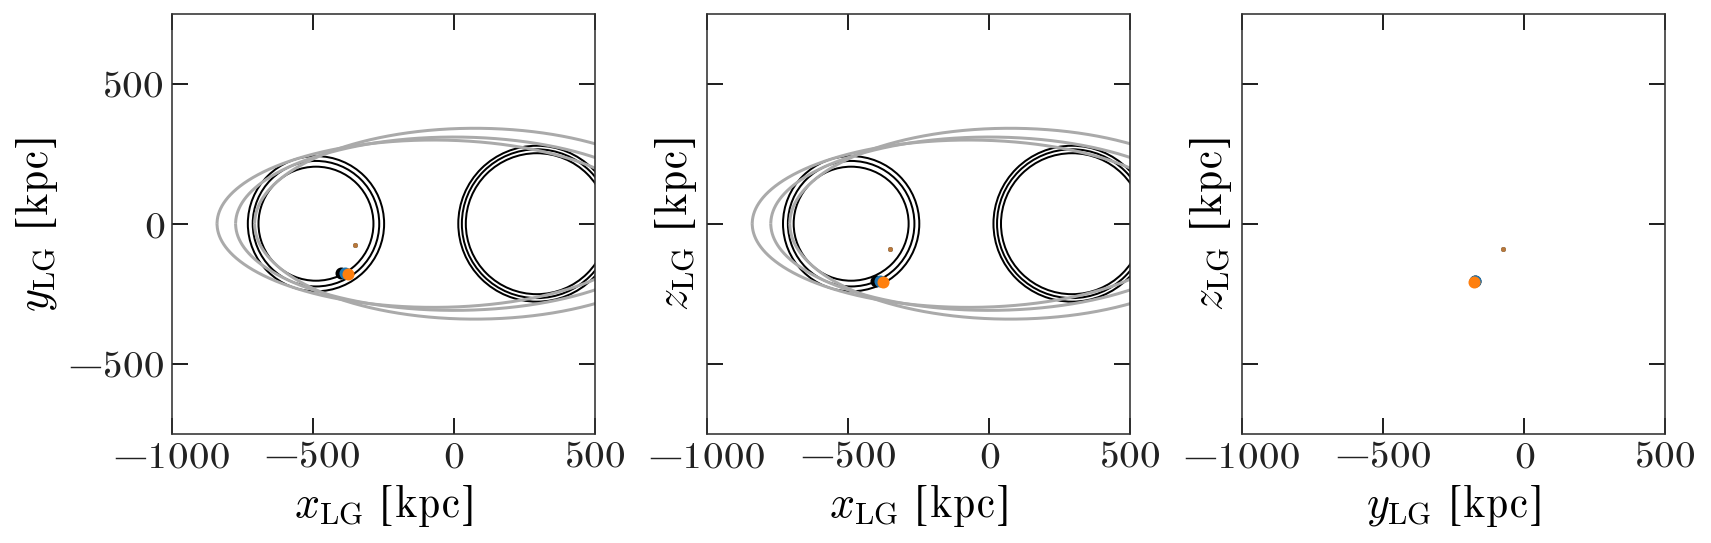

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                             sharex=True, sharey=True)

for key in models:
# for key in ['1.2']:
    q = qs[key]
    rstar = rstars[key]
    _mw_xyz = models[key]['mw_xyz'].to(u.kpc).value
    _m31_xyz = models[key]['m31_xyz'].to(u.kpc).value
    mw_rvir = models[key]['mw_rvir']
    m31_rvir = models[key]['m31_rvir']
    closest_ell_xyz = closest_ell_xyzs[key]
    
    mw_1_2_x = models['1.2']['mw_xyz'].to(u.kpc).value[0]
    dx = models[key]['mw_xyz'].to(u.kpc).value[0] - mw_1_2_x

    i = np.where(_mask)[0]

    y1 = q * np.sqrt(rstar**2 - xgrid**2)
    y2 = -q * np.sqrt(rstar**2 - xgrid**2)
    axes[0].plot(xgrid - dx, y1, marker='', color='#aaaaaa')
    axes[0].plot(xgrid - dx, y2, marker='', color='#aaaaaa')
    axes[1].plot(xgrid - dx, y1, marker='', color='#aaaaaa')
    axes[1].plot(xgrid - dx, y2, marker='', color='#aaaaaa')

    style = dict(marker='.', linestyle='none', alpha=0.65)
    _mask = nearby['GalaxyName'] == 'PiscesII'

    axes[0].plot((c_barycens[key].cartesian.xyz[0].to_value(u.kpc) - dx)[_mask],
                   c_barycens[key].cartesian.xyz[1][_mask],
                   **style)
    axes[1].plot((c_barycens[key].cartesian.xyz[0].to_value(u.kpc) - dx)[_mask],
                   c_barycens[key].cartesian.xyz[2][_mask],
                   **style)
    axes[2].plot(c_barycens[key].cartesian.xyz[1][_mask],
                   c_barycens[key].cartesian.xyz[2][_mask],
                   **style)

    axes[0].scatter(closest_ell_xyz[0, i] - dx,
                      closest_ell_xyz[1, i])
    axes[1].scatter(closest_ell_xyz[0, i] - dx,
                      closest_ell_xyz[2, i])
    axes[2].scatter(closest_ell_xyz[1, i],
                      closest_ell_xyz[2, i])

    axes[0].set_xlim(-1000, 500)
    axes[0].set_ylim(-750, 750)

    axes[0].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[0].set_ylabel(r'$y_{\rm LG}$ [kpc]')
    axes[1].set_xlabel(r'$x_{\rm LG}$ [kpc]')
    axes[1].set_ylabel(r'$z_{\rm LG}$ [kpc]')
    axes[2].set_xlabel(r'$y_{\rm LG}$ [kpc]')
    axes[2].set_ylabel(r'$z_{\rm LG}$ [kpc]')

    for ax in axes[:2]:
        ax.add_patch(mpl.patches.Circle(
            (mw_1_2_x, 0), radius=mw_rvir.to_value(u.kpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))

        ax.add_patch(mpl.patches.Circle(
            (_m31_xyz[0] - dx, 0), radius=m31_rvir.to_value(u.kpc),
            facecolor='none', lw=1., edgecolor='k', zorder=-100))

    fig.tight_layout()